In [3]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
DATA_DIR = "/mnt/ernie_main/Ghassan/ephys/data/periconnectivity"
peri_fs = glob.glob(os.path.join(DATA_DIR, "*pat*.csv"))

peri_df = pd.read_csv(peri_fs[-1])

In [57]:
18*1390

25020

In [75]:
 
peri_df[peri_df.period==1390]
event_df = peri_df.loc[0:25037]
event_df = event_df.reset_index()

# event_df['eventID'] = 1   

In [73]:
set(windows)

{'0.0_0.0_0.0',
 '0.0_0.0_1.0',
 '0.0_1.0_1.0',
 '1.0_1.0_1.0',
 '1.0_1.0_2.0',
 '1.0_2.0_2.0',
 '2.0_2.0_2.0'}

In [86]:
windows = event_df.window_designations
transition = np.where(windows == "0.0_0.0_1.0")[0]
utransition_ind = transition[0]
trans_period = event_df.period.values[transition_ind]
centered_wins = event_df.period.values - trans_period
event_df["win_sz_ctrd"] = centered_wins

trans_df = event_df.loc[transition]
trans_period = trans_df.period.values[0]
event_df['win_sz_centered'] = event_df.period - trans_period
event_df

,index,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,subj,sz_type,win_sz_centered,win_sz_ctrd
0,0,0,soz,-0.064993,-0.072037,-0.007044,delta,0.0_0.0_0.0,Spat52,FIAS,-595,-595
1,1,0,pz,NaN,NaN,NaN,delta,0.0_0.0_0.0,Spat52,FIAS,-595,-595
2,2,0,nz,0.004149,0.004598,0.000450,delta,0.0_0.0_0.0,Spat52,FIAS,-595,-595
3,3,0,soz,-0.093501,-0.078826,0.014675,theta,0.0_0.0_0.0,Spat52,FIAS,-595,-595
4,4,0,pz,NaN,NaN,NaN,theta,0.0_0.0_0.0,Spat52,FIAS,-595,-595
...,...,...,...,...,...,...,...,...,...,...,...,...
25033,25033,1390,pz,NaN,NaN,NaN,gamma_l,2.0_2.0_2.0,Spat52,FIAS,795,795
25034,25034,1390,nz,0.031012,0.016637,-0.014374,gamma_l,2.0_2.0_2.0,Spat52,FIAS,795,795
25035,25035,1390,soz,-0.271394,-0.266740,0.004654,gamma_H,2.0_2.0_2.0,Spat52,FIAS,795,795
25036,25036,1390,pz,NaN,NaN,NaN,gamma_H,2.0_2.0_2.0,Spat52,FIAS,795,795


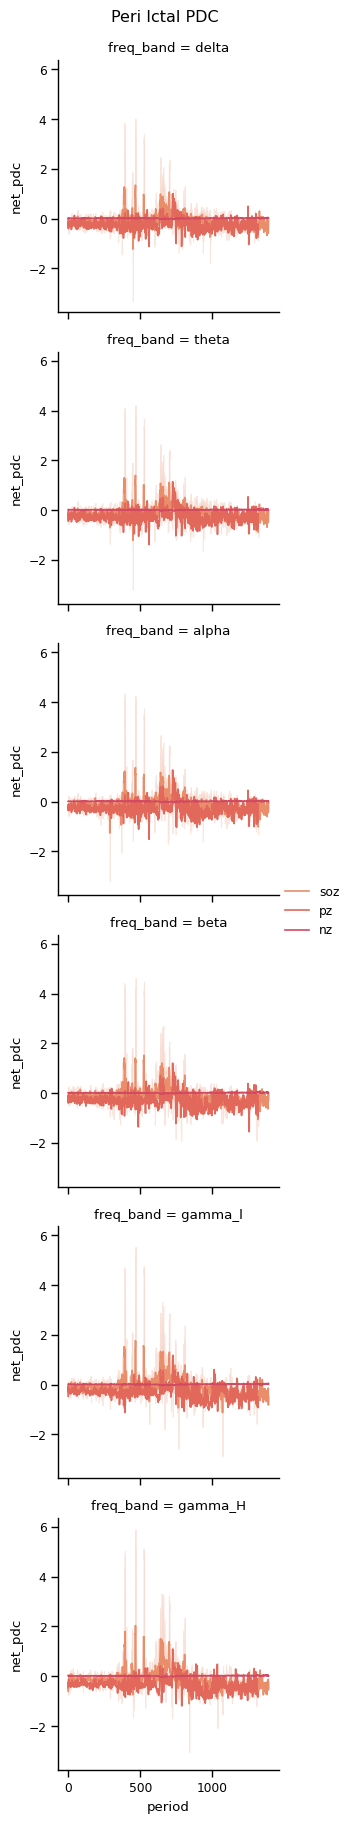

In [28]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(peri_df, row='freq_band',row_order=['delta','theta','alpha', 'beta','gamma_l','gamma_H']) 
        grid.map_dataframe(sns.lineplot, y='net_pdc',x='period', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal PDC",y=1.01)
        plt.savefig("../viz/peri_Epat_02_peri_pdc.pdf",transparent=True)


TODO:
1. Label backwards from first seizure window
1. sample 5 windows in seizure span
1. align seizure end windows
1. aggregate all subjs

In [30]:
peri_df

,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,subj,sz_type
0,0,soz,-0.064993,-0.072037,-0.007044,delta,0.0_0.0_0.0,Spat52,FIAS
1,0,pz,NaN,NaN,NaN,delta,0.0_0.0_0.0,Spat52,FIAS
2,0,nz,0.004149,0.004598,0.000450,delta,0.0_0.0_0.0,Spat52,FIAS
3,0,soz,-0.093501,-0.078826,0.014675,theta,0.0_0.0_0.0,Spat52,FIAS
4,0,pz,NaN,NaN,NaN,theta,0.0_0.0_0.0,Spat52,FIAS
...,...,...,...,...,...,...,...,...,...
95845,1318,pz,-0.494625,-0.328764,0.165860,gamma_l,2.0_2.0_2.0,Spat52,FIAS
95846,1318,nz,0.041097,0.018144,-0.022953,gamma_l,2.0_2.0_2.0,Spat52,FIAS
95847,1318,soz,-0.767384,-0.233676,0.533708,gamma_H,2.0_2.0_2.0,Spat52,FIAS
95848,1318,pz,-0.635416,-0.337736,0.297680,gamma_H,2.0_2.0_2.0,Spat52,FIAS


In [35]:
tst = peri_df[peri_df.freq_band =='alpha']
tst = tst[tst.region =='soz']
tst[tst.window_designations == '0.0_1.0_1.0']

,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,subj,sz_type
10770,598,soz,-0.231942,-0.178899,0.053043,alpha,0.0_1.0_1.0,Spat52,FIAS
10788,599,soz,-0.044067,-0.071976,-0.027909,alpha,0.0_1.0_1.0,Spat52,FIAS
35808,598,soz,-0.070086,-0.066473,0.003613,alpha,0.0_1.0_1.0,Spat52,FIAS
35826,599,soz,-0.023353,-0.033859,-0.010506,alpha,0.0_1.0_1.0,Spat52,FIAS
59406,598,soz,-0.110572,-0.013025,0.097547,alpha,0.0_1.0_1.0,Spat52,FAS
59424,599,soz,-1.624492,-0.066497,1.557994,alpha,0.0_1.0_1.0,Spat52,FAS
82878,598,soz,0.535177,0.378955,-0.156222,alpha,0.0_1.0_1.0,Spat52,FIAS
82896,599,soz,0.347449,0.287193,-0.060255,alpha,0.0_1.0_1.0,Spat52,FIAS


In [33]:
Counter(tst.window_designations)

Counter({'0.0_0.0_0.0': 2380,
         '2.0_2.0_2.0': 2380,
         '1.0_1.0_1.0': 525,
         '0.0_0.0_1.0': 12,
         '1.0_1.0_2.0': 12,
         '0.0_1.0_1.0': 8,
         '1.0_2.0_2.0': 8})